### SkimLit (skimming the Literature)

Using Natural Language Processing to make reading medical abtracts easier or Sequential Sentence Classification in Medical abstracts.


### The Overview of the things we'wil be working on :

* Downloading a text dataset (PubMed 200k RCT)

* Writing a preprocessing function for our text data

* Setting up multiple modelling experiments with different levels of embeddings

* Building a multimodal model to take in different sources of data

* Finding the most Wrong prediction

Research Paper : https://arxiv.org/abs/1710.06071



In [ ]:
## Confirm access to GPU
!nvidia-smi-L

/bin/bash: line 1: nvidia-smi-L: command not found


## Get the data

Since we'll be replecating the paper above Lets download the dataset :
https://github.com/Franck-Dernoncourt/pubmed-rct


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (33/33), 177.08 MiB | 17.79 MiB/s, done.
Resolving deltas: 100% (12/12), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# Check what files are in the PUbMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20k dataset with numberes replaced by '@' sign
data_dir ="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess Data


In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Reads filename (a text filename ) and returns the lines of text as list

  Args :
    filename : a string containing the target file

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename , 'r') as f:
    return f.readlines()


In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

# Let's think about how we want our data to look

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text' : Emotional eating is a..... obesity.\n
    'total_lines':11}]
```

In [ ]:
def preprocess_text_with_line_number(filename):
  """
  Returns a list of dictionary of abstract line data.

  Takes in filename , reads it contents and sorts through each lines ,
  extracting things like the target label , text of the sentence ,
  how many sentences are in the current abstract and what sentence number the target line is

  """
  input_lines = get_lines(filename)

  abstract_lines =""

  abstract_samples =[]

  for line in input_lines:
    if(line.startswith("###")):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace(): # Check to seee if line is new line
      abstract_line_split = abstract_lines.splitlines() # split abstract int o separate lines
      for  abstract_line_number , abstract_line in enumerate(abstract_line_split):
        line_data ={}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["line_number"] = abstract_line_number
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()

        line_data["total_lines"] = len(abstract_line_split)-1
        abstract_samples.append(line_data)

    else: # if the above condition aren't fulfilled the line contains a labelled sentence
      abstract_lines +=line


  return abstract_samples









In [ ]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_number(data_dir + "train.txt")
val_samples = preprocess_text_with_line_number(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_number(data_dir + "test.txt")

print(len(train_samples) , len(val_samples) , len(test_samples))

180040 30212 30135


In [ ]:
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

Now we've the data in the form of dictionary so we will use pandas DataFrame to visulize

In [ ]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
test_df =pd.DataFrame(test_samples)
val_df =pd.DataFrame(val_samples)
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [ ]:
# Distribution of labels

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

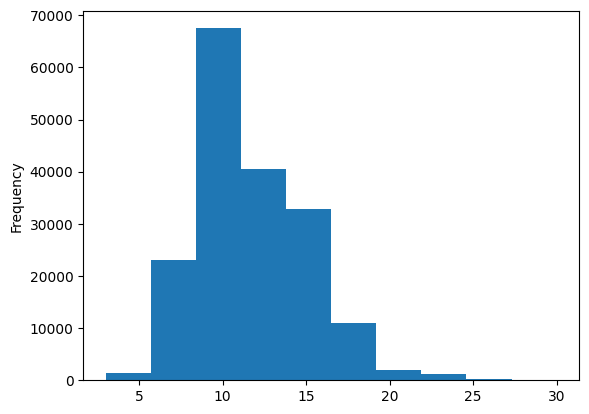

In [ ]:
# lets check length of different lines
train_df.total_lines.plot.hist()

### Gets list of Sentences


In [ ]:
# Convert abstract text lines into list

train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()



## Making Numerical labels

In [ ]:
# one hot encoding labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder =OneHotEncoder(sparse =False)
train_labels_one_hot =one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot =one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot =one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels


In [ ]:
# Extract labels and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())


train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from Label Encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Baseline Model( TF- IDF Multinomial Naive Bayes classifier)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf" , TfidfVectorizer()),
    ("clf" , MultinomialNB())
])

model_0.fit(X = train_sentences ,
            y = train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score( val_sentences , val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)

## Downloading the Helper Functions


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-29 15:56:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-29 15:56:20 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results


In [ ]:
baseline_results = calculate_results(val_labels_encoded , baseline_preds)

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text ) for deep sequence model
before we start building models , we've got to create vectorization and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([1.25846e+05, 4.78220e+04, 5.37600e+03, 7.86000e+02, 1.46000e+02,
        3.20000e+01, 1.90000e+01, 8.00000e+00, 3.00000e+00, 2.00000e+00]),
 array([  1. ,  30.5,  60. ,  89.5, 119. , 148.5, 178. , 207.5, 237. ,
        266.5, 296. ]),
 <BarContainer object of 10 artists>)

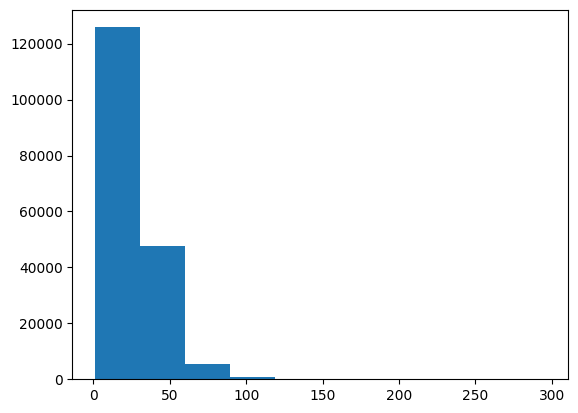

In [ ]:
# Whats the distribution looks like
import matplotlib.pyplot as plt
plt.hist(sent_lens)

In [ ]:
# How long of a sentence length covers 95% of examples ?
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

In [ ]:
# amx sequence length
max(sent_lens)

296

## Creating a text vectorization layer

In [ ]:
#  How many words are there in vocab ?
max_tokens = 68000 # from paper

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
text_vectorizer = TextVectorization( max_tokens = max_tokens ,# number of words in vocabulary
                                   output_sequence_length = output_seq_len) # desired output length of vectorized sequence


In [ ]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text: \n{target_sentence}")
print(f"\n Length of text : {len(target_sentence)}")
print(f"\n Vectorized text : {text_vectorizer([target_sentence])}")


Text: 
the poly ( adp-ribose ) polymerase inhibitor olaparib has shown antitumour activity in patients with platinum-sensitive , recurrent , high-grade serous ovarian cancer with or without brca@ or brca@ mutations .

 Length of text : 209

 Vectorized text : [[    2 18147 41372  4062   738  6618   139   512 12815   190     5    12
      7 10211   857  5074 11405  1630   135     7    16   159  6980    16
   6980  2182     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in our training vocabulary
rct_20k_text_vocab =text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in vocab: {rct_20k_text_vocab[-5:]}")


Number of words in vocab: 64841
Most common words in vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# get config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create a embeeding layer


In [ ]:
embedding = tf.keras.layers.Embedding(input_dim = len(rct_20k_text_vocab),
                                      output_dim = 128 ,
                                      mask_zero = True , # use masking to handle variable sequence length
                                      name = "token_embedding"
                                      )

In [ ]:
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization:\n{vectorized_sentence}")
embedded_sentence = embedding(vectorized_sentence)
print(f"Embedded sentence:{embedded_sentence} ")
print(f"Sentence after embedding shape :{embedded_sentence.shape}")

Sentence before vectorization:
 the poly ( adp-ribose ) polymerase inhibitor olaparib has shown antitumour activity in patients with platinum-sensitive , recurrent , high-grade serous ovarian cancer with or without brca@ or brca@ mutations .

Sentence after vectorization:
[[    2 18147 41372  4062   738  6618   139   512 12815   190     5    12
      7 10211   857  5074 11405  1630   135     7    16   159  6980    16
   6980  2182     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
Embedded sentence:[[[-0.02793475 -0.03860072 -0.04744359 ...  0.01072931  0.03814108
   -0.04390776]
  [-0.01794804 -0.01065695 -0.04916709 ... -0.01745099  0.012011
   -0.01537843]
  [-0.04689921 -0.04074175 -0.04378203 ...  0.04422862  0.03226158
   -0.01255767]
  ...
  [-0.01445936 -0.02974191  0.01767823 ... -0.036391   -0.02840061
   -0.03747735]
  [-0.01445936 -0.02974191  0.0

## Creating datasets (making sure our data loads as fast as possible )
`tf.dataAPI`

In [ ]:
# Turn our data into tensorflow datasets

train_dataset =  tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))

valid_dataset =  tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))

test_dataset =  tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape ,train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
len(train_dataset)

5627

In [ ]:
# Create 1d conv model to process sequences

inputs = layers.Input(shape =(1,) , dtype = tf.string)
text_vectors = text_vectorizer(inputs)
token_embedding = embedding(text_vectors)

x = layers.Conv1D(64 , kernel_size = 5 , padding ="same" , activation ="relu")(token_embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes , activation ="softmax")(x)

model_1 = tf.keras.Model(inputs , outputs)

# compile
model_1.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])




In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_1 = model_1.fit(train_dataset ,
                        epochs = 3,
                        steps_per_epoch =int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)) # only validate on 10% batches
                        )

Epoch 1/3
562/562 [==============================] - 61s 90ms/step - loss: 0.9189 - accuracy: 0.6368 - val_loss: 0.6809 - val_accuracy: 0.7440
Epoch 2/3
562/562 [==============================] - 15s 26ms/step - loss: 0.6525 - accuracy: 0.7611 - val_loss: 0.6240 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6133 - accuracy: 0.7770 - val_loss: 0.5945 - val_accuracy: 0.7839


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5955 - accuracy: 0.7874


[0.5954912900924683, 0.7873692512512207]

In [ ]:
model_1_pred_probs =model_1.predict(valid_dataset)
model_1_pred_probs , model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.3914899e-01, 1.6607210e-01, 9.2641883e-02, 2.7141267e-01,
         3.0724332e-02],
        [4.9022496e-01, 2.2363946e-01, 1.5710013e-02, 2.6250347e-01,
         7.9220450e-03],
        [1.3341144e-01, 6.8597980e-03, 1.0676550e-03, 8.5863686e-01,
         2.4290413e-05],
        ...,
        [4.0150699e-06, 5.0886709e-04, 3.9985793e-04, 3.1070645e-06,
         9.9908412e-01],
        [5.1521037e-02, 4.2518562e-01, 1.3312127e-01, 6.7439511e-02,
         3.2273248e-01],
        [1.6555296e-01, 7.1600682e-01, 3.1292044e-02, 3.4869220e-02,
         5.2278884e-02]], dtype=float32),
 (30212, 5))

In [ ]:
model_1_pred = tf.argmax(model_1_pred_probs , axis =1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# calculate model_1 results
model_1_results = calculate_results(y_true = val_labels_encoded , y_pred = model_1_pred)

In [ ]:
model_1_results

{'accuracy': 78.73692572487752,
 'precision': 0.7840962067260441,
 'recall': 0.7873692572487753,
 'f1': 0.7847388528535986}

### Model 2

### TensorFlow feature extraction Model
Model -2

The paper originally used Glove Embedding but we will use universal sentence encoder
https://tfhub.dev/google/universal-sentence-encoder/4

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                 trainable = False ,
                                 name = "universal_sentence_encoder")

In [ ]:
# Test out pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence :\n {random_train_sentence }\n")
use_embedded_layer = embedding_layer([random_train_sentence])
print(f"Embedding :\n {use_embedded_layer}\n")

Random Sentence :
 a total of @ insulin nave t@d patients with a glycated haemoglobin ( hba@c ) level of > @ % in the previous @months while treated with maximal oral therapy will be recruited and screened from @ primary care practices in melbourne , australia .

Embedding :
 [[-0.06167687  0.06177733 -0.06413677 -0.06378554 -0.04480933 -0.03488617
   0.03520672 -0.00367376  0.07405239 -0.00276613  0.08706523  0.05656193
  -0.0500537   0.06952361  0.04772016  0.03079166 -0.08704296 -0.00970537
  -0.06208821  0.04654246 -0.03823572  0.07736712  0.01333825  0.02695845
   0.07585987  0.07764047 -0.01394559 -0.02142914 -0.02407107 -0.03857096
  -0.04414008  0.08829357 -0.02961429  0.04839761  0.01402156 -0.01231481
   0.02070307  0.00531124 -0.07193382  0.01295816 -0.04420404  0.02380088
  -0.00437251 -0.07180227  0.03798198  0.06222788 -0.01852695 -0.00446234
  -0.07835004 -0.02090537 -0.07089062 -0.00639053 -0.04166368 -0.05251575
   0.022969   -0.04533266 -0.08205084 -0.08298326  0.0735

In [ ]:
inputs = layers.Input(shape =[] , dtype = tf.string)
x = embedding_layer(inputs) # tokenixe text and create a embedding
x =layers.Dense(128 , activation ="relu")(x)
output = layers.Dense(num_classes , activation ="softmax")(x)

model_2 = tf.keras.Model(inputs , output )

# compile the model

model_2.compile(loss = "categorical_crossentropy" ,
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [ ]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_2 = model_2.fit(train_dataset,
                     epochs = 3,
                     steps_per_epoch = int(0.1*len(train_dataset)),
                     validation_data = valid_dataset ,
                     validation_steps = int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 11s 15ms/step - loss: 0.9191 - accuracy: 0.6503 - val_loss: 0.7963 - val_accuracy: 0.6868
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7693 - accuracy: 0.7007 - val_loss: 0.7540 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7527 - accuracy: 0.7130 - val_loss: 0.7378 - val_accuracy: 0.7148


In [ ]:
# Evaluate on validation dataset

model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7413 - accuracy: 0.7145


[0.741288423538208, 0.7144511938095093]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred = tf.argmax(model_2_pred_probs , axis = 1)

945/945 [==============================] - 10s 11ms/step


In [ ]:
model_2_results = calculate_results(y_true = val_labels_encoded, y_pred = model_2_pred)

In [ ]:
model_2_results

{'accuracy': 71.44512114391632,
 'precision': 0.7147112044198205,
 'recall': 0.7144512114391632,
 'f1': 0.7113211322465057}

# Model 3 - Conv1D with character embeddings

Our research paper used character and token and character embedding
our model 1 was based on token embedding

### Create a character - level vectorizer



In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
def split_chars(text):
  return " ".join(list(text))



In [ ]:
hi = split_chars(" HI i am chinmay")

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars (sentence ) for sentence in val_sentences]
test_chars = [split_chars (sentence ) for sentence in test_sentences]
train_chars

In [ ]:
# Average character length
chars_len = [len(sentence) for sentence in train_sentences]
mean_char_len =np.mean(chars_len)

In [ ]:
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

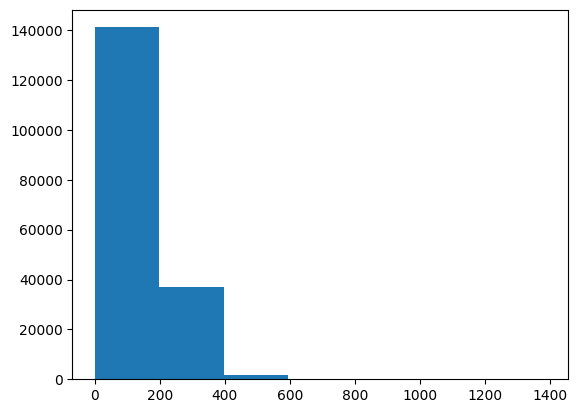

In [ ]:
# Check the distribution of char length
plt.hist(chars_len , bins =7)

In [ ]:
# Find what chracter length covers 95% of sequence
output_seq_char_len = int (np.percentile(chars_len , 95))
output_seq_char_len

290

In [ ]:
# get all the keyboard characters
random.choice(train_sentences)
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) +2  # add for space and [unk]
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS ,
                                    output_sequence_length = output_seq_char_len,
                                    #standardize = None,
                                    name="char_vectorizer")

In [ ]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of diffrent character in vocab : {len(char_vocab)}")
print(f"5 most common character : {char_vocab[:5]}")
print(f"5 least common character : {char_vocab[-5:]}")

Number of diffrent character in vocab : 28
5 most common character : ['', '[UNK]', 'e', 't', 'i']
5 least common character : ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\n Length of Random chars sentence:\n {len(random_train_chars)}")
vectorized_char = char_vectorizer([random_train_chars])
print(f"\nvectorized char:\n {vectorized_char}")
print(f"\nvectorized chars length:\n {len(vectorized_char[0])}")


Charified text:
 s e l f - m a n a g e m e n t   a p p r o a c h e s   a r e   n e e d e d   t o   a v o i d   c a t h e t e r - r e l a t e d   p r o b l e m s   .

 Length of Random chars sentence:
 147

vectorized char:
 [[ 9  2 12 17 15  5  6  5 18  2 15  2  6  3  5 14 14  8  7  5 11 13  2  9
   5  8  2  6  2  2 10  2 10  3  7  5 21  7  4 10 11  5  3 13  2  3  2  8
   8  2 12  5  3  2 10 14  8  7 22 12  2 15  9  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  

## char level embedding


In [ ]:
char_embed = layers.Embedding(input_dim = len(char_vocab),
                              output_dim = 25,
                              mask_zero =True ,
                              name = "char_embed")

In [ ]:
# Test our char level embedding

print(f"Charified Texr :\n {random_train_chars}")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"\n Embedded char:\n {char_embed_example}")
print(f"\nvectorized chars shape:\n {char_embed_example.shape}")

Charified Texr :
 s e l f - m a n a g e m e n t   a p p r o a c h e s   a r e   n e e d e d   t o   a v o i d   c a t h e t e r - r e l a t e d   p r o b l e m s   .

 Embedded char:
 [[[-4.5270193e-02 -4.4128407e-02  1.0119665e-02 ...  2.1721367e-02
   -4.7200181e-02  2.7862180e-02]
  [-3.1439207e-02 -1.0847531e-02  4.4624928e-02 ... -2.5354326e-05
   -4.9670853e-02 -7.6055527e-03]
  [ 1.9531216e-02  5.1264167e-03  3.7248101e-02 ...  4.9660277e-02
   -4.6617534e-02 -3.3841923e-02]
  ...
  [-1.8653095e-02  1.0618638e-02  3.4765724e-02 ... -3.6816381e-02
   -3.6595929e-02 -1.8652391e-02]
  [-1.8653095e-02  1.0618638e-02  3.4765724e-02 ... -3.6816381e-02
   -3.6595929e-02 -1.8652391e-02]
  [-1.8653095e-02  1.0618638e-02  3.4765724e-02 ... -3.6816381e-02
   -3.6595929e-02 -1.8652391e-02]]]

vectorized chars shape:
 (1, 290, 25)


### Model -3 : With character embedding

In [ ]:
inputs = layers.Input(shape =(1,) , dtype ="string")
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64 , kernel_size = 15 , padding ="same" , activation ="relu" )(x)
x = layers.GlobalMaxPooling1D()(x)
#x = layers.Dense(128 , activation ="relu")(x)
outputs = layers.Dense(num_classes , activation ="softmax")(x)
model_3 = tf.keras.Model(inputs , outputs)


In [ ]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           24064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)                 325 

In [ ]:
model_3.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),

                metrics = ["accuracy"])


In [ ]:
# prefetch data set for char level dataset

train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_3 = model_3.fit(train_char_dataset ,
                        epochs = 3,
                        steps_per_epoch = int(0.1* len(train_char_dataset)),
                        validation_data = val_char_dataset,
                        validation_steps = int(0.1*len(val_char_dataset))),


Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 1.1973 - accuracy: 0.5136 - val_loss: 0.9657 - val_accuracy: 0.6207
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.9166 - accuracy: 0.6410 - val_loss: 0.8389 - val_accuracy: 0.6752
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.8389 - accuracy: 0.6749 - val_loss: 0.7797 - val_accuracy: 0.7061


In [ ]:
model_3_pred_probs = model_3.predict(val_char_dataset)

945/945 [==============================] - 2s 3ms/step


In [ ]:
model_3_pred = tf.argmax(model_3_pred_probs , axis =1)

In [ ]:
# calculate model results
model_3_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred = model_3_pred)

In [ ]:
model_3_results

{'accuracy': 69.4095061564941,
 'precision': 0.6860707731904779,
 'recall': 0.694095061564941,
 'f1': 0.6841448070756626}

### Model 4 : Combining pretrained token embedding + characters embedding (hybrid)


1. create a token - level embedding model
2. create a character - level model
3. combine 1 & 2 with a concatenate (`layers.concatenate`)

In [ ]:
# 1. Token input model
inputs_token = layers.Input(shape = [], dtype = "string" , name ="token_input")
token_embeddings = embedding_layer(inputs_token)
token_output = layers.Dense(128 , activation ="relu")(token_embeddings)
token_model = tf.keras.Model(inputs_token ,token_output )


# 2. Char input model
inputs_char = layers.Input(shape = (1,) , dtype ="string")
char_V = char_vectorizer(inputs_char)
char_embedding = char_embed(char_V)
char_bi_LSTM = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs_char , char_bi_LSTM)

# 3. Concatenate token and cahr inputs
token_char_concat = layers.concatenate([token_model.output,
                                                         char_model.output])

# 4. series of layers

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128 , activation ="relu")(combined_dropout)
combined_dropout = layers.Dropout(0.5)(combined_dense)
outputs = layers.Dense(num_classes , activation ="softmax")(combined_dropout)
model_4 = tf.keras.Model(inputs = [token_model.input , char_model.input] , outputs= outputs ,
                         name = "model_4_token_and_char_embedding")





In [ ]:
model_4.summary()

Model: "model_4_token_and_char_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_4[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['

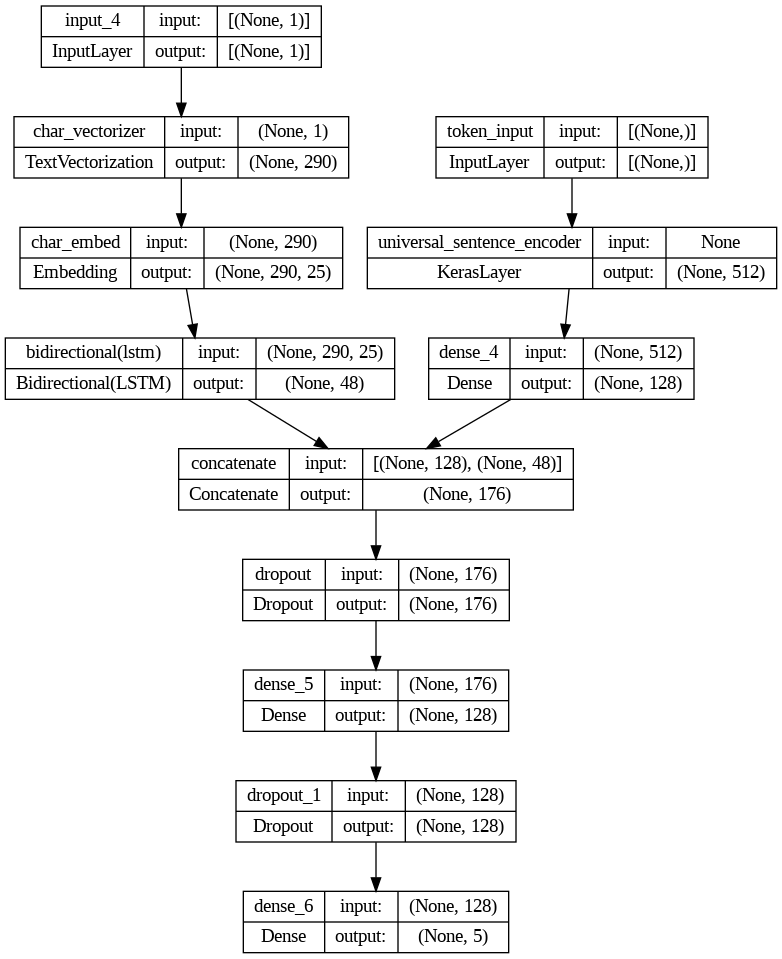

In [ ]:
from keras.utils import plot_model
plot_model(model_4 , show_shapes =True)

In [ ]:
model_4.compile(loss = "categorical_crossentropy" ,
                optimizer= tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])



In [ ]:
train_dataset =  tf.data.Dataset.from_tensor_slices(((train_sentences , train_chars) , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset =  tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars) , val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset =  tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars) , test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
histoty_4 = model_4.fit(train_dataset ,
                        epochs = 3,
                        steps_per_epoch =int(0.1*len(train_dataset)),
                        validation_data = valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)) # only validate on 10% batches
                        )

Epoch 1/3
562/562 [==============================] - 51s 66ms/step - loss: 0.9811 - accuracy: 0.6104 - val_loss: 0.7820 - val_accuracy: 0.6985
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.8020 - accuracy: 0.6883 - val_loss: 0.7128 - val_accuracy: 0.7311
Epoch 3/3
562/562 [==============================] - 25s 44ms/step - loss: 0.7801 - accuracy: 0.7037 - val_loss: 0.6891 - val_accuracy: 0.7387


In [ ]:
model_4.evaluate(valid_dataset)


945/945 [==============================] - 24s 26ms/step - loss: 0.6964 - accuracy: 0.7356


[0.696376621723175, 0.735568642616272]

In [ ]:
model_4_pred_probs = model_4.predict(valid_dataset)
model_4_pred = tf.argmax(model_4_pred_probs,axis =1)


945/945 [==============================] - 32s 29ms/step


In [ ]:
model_4_results = calculate_results(val_labels_encoded,model_4_pred)

In [ ]:
model_4_results

{'accuracy': 73.55686482192506,
 'precision': 0.7358567182625645,
 'recall': 0.7355686482192506,
 'f1': 0.7322209179982454}

In [ ]:
baseline_results


{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

### Model 5: Pretrained token embeddings + character embeddings + positional embeddings


In [ ]:
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,a total of @ patients with primary knee oa wer...,11
2,2,METHODS,outcome measures included pain reduction and i...,11
3,3,METHODS,pain was assessed using the visual analog pain...,11
4,4,METHODS,secondary outcome measures included the wester...,11


In [ ]:
# How many different line_numbers are there?

train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

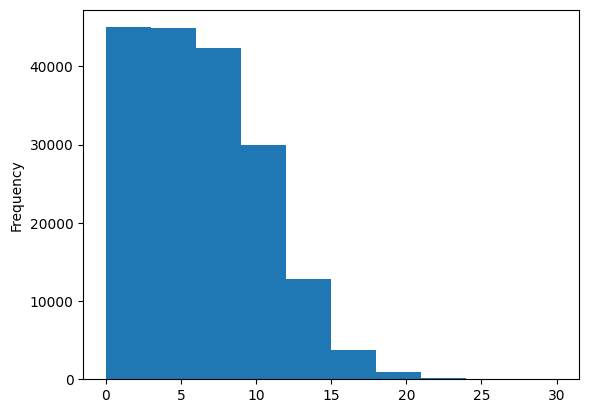

In [ ]:
# checck the distribution of line_number colums
train_df.line_number.plot.hist()

In [ ]:
# Use tensorflow to create one-hot encode line_number
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth =16)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth =16)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),depth =16)

In [ ]:
train_line_numbers_one_hot[:10] , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 16), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 16]))

In [ ]:
# how is the distribution of total lines
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

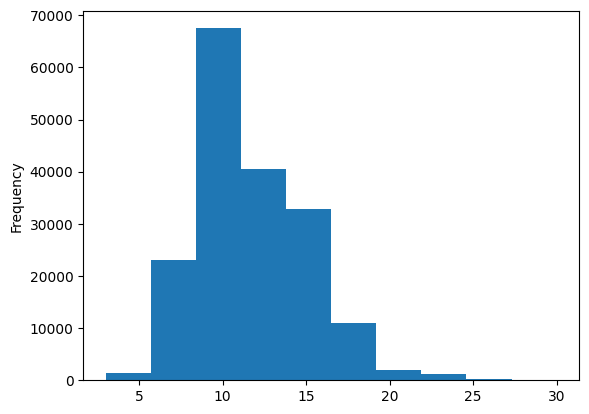

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
# Check the coverage of a "total_line"
np.percentile(train_df.total_lines , 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy() , depth =20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy() , depth =20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy() , depth =20)

In [ ]:
train_total_lines_one_hot.shape

TensorShape([180040, 20])

### Building a tribrid embedding model

1. create a token-level model
2. create a char - level model
3. create a model for "line_number" feature
4. create a model for "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.concatenate
6. combine the outputs of 3,4,5 using tf.keras.layers.concatenate


In [ ]:
# Number 1 Token inputs

token_inputs = layers.Input(shape =[] ,dtype = "string")
token_embeddings = embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation ="relu")(token_embeddings)
token_model= tf.keras.Model(inputs = token_inputs , outputs = token_outputs)

# Number 2 char inputs

char_inputs = layers.Input(shape = (1,) , dtype ="string")
char_vector = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vector)
x = layers.Bidirectional(layers.LSTM(64))(char_embeddings)
#char_outputs = layers.Dense(128 , activation ="relu")(x)
char_model = tf.keras.Model(char_inputs , x)


# Number 3 Model for line_number

line_inputs = layers.Input(shape = (16,) , dtype = tf.float32 , name ="line_number_input")
x = layers.Dense(32 , activation = "relu")(line_inputs)

line_model = tf.keras.Model(line_inputs , x)

# Number 4 Model for line number

total_line_inputs = layers.Input(shape = (20,) , dtype = tf.float32 , name = "total_line_input")
y = layers.Dense(32 , activation = "relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs , y)


# Number 5 : combining 1,2
token_char_concat = layers.Concatenate(name ="char_token_hybrid_embedding")([token_model.output , char_model.output])

z = layers.Dense(256 , activation ="relu")(token_char_concat)
z = layers.Dropout(0.5)(z)
# Number 6 combinig 3,4,5

line_total_tc_concat = layers.Concatenate(name = "Tribrid_embedding")([line_model.output ,
                                           total_line_model.output ,
                                            z])
# Number 7 Output layer
outputs = layers.Dense(num_classes , activation ="softmax")(line_total_tc_concat)

# Number 8 : Model
model_5 = tf.keras.Model(inputs =[token_model.input ,char_model.input , line_model.input , total_line_model.input] ,
                         outputs = outputs)



In [ ]:
model_5.summary()

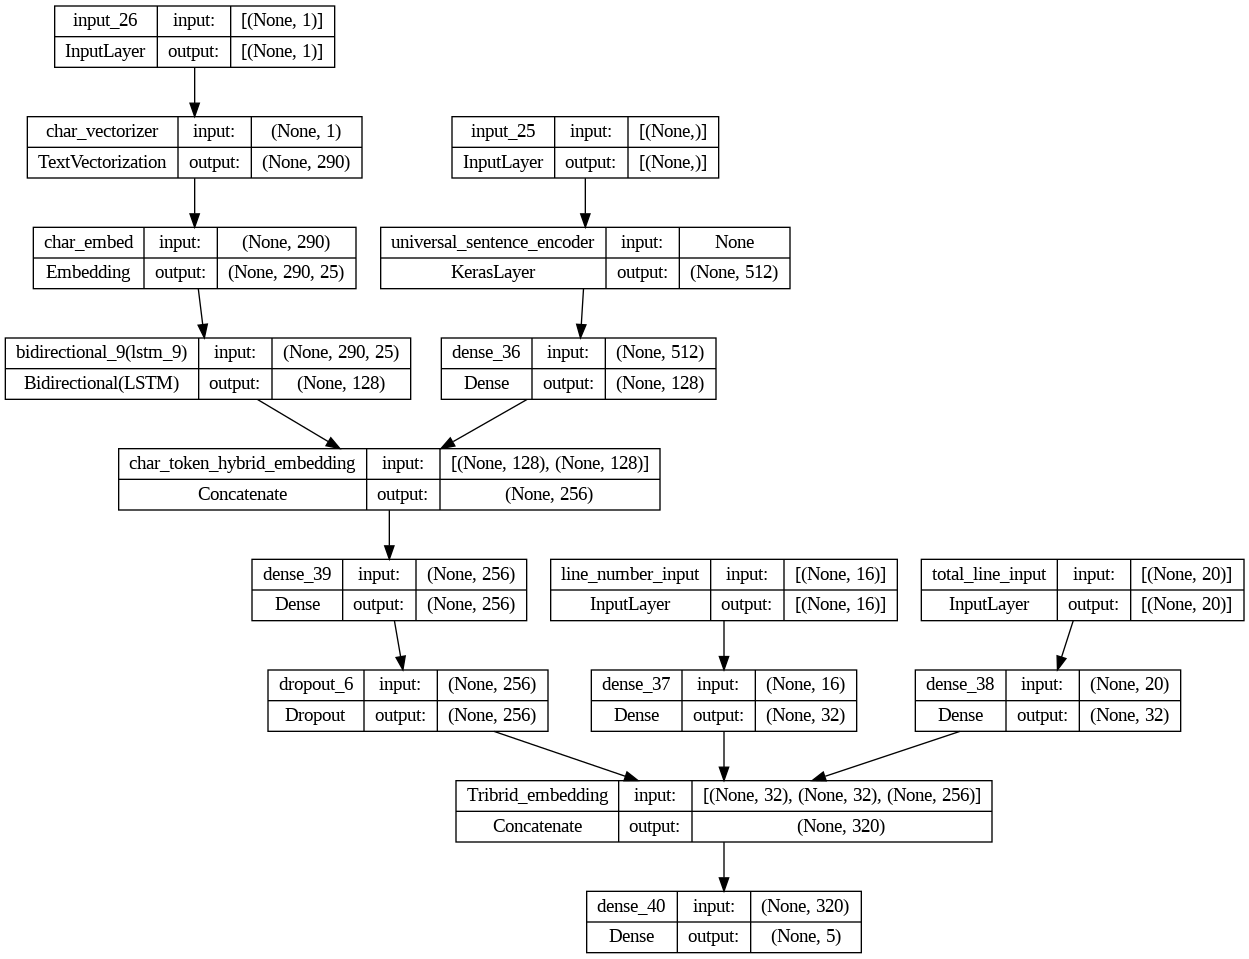

In [ ]:
from keras.utils import plot_model
plot_model(model_5, show_shapes =True)

In [ ]:
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing =0.2), # helps to prevent overfitting
                optimizer = tf.keras.optimizers.Adam(),
                metrics =["accuracy"])

In [ ]:
# Creating a training and validation datasets(with all four kinds of input data)

train_dataset =  tf.data.Dataset.from_tensor_slices(((train_sentences , train_chars , train_line_numbers_one_hot ,train_total_lines_one_hot) , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset =  tf.data.Dataset.from_tensor_slices(((val_sentences, val_chars ,val_line_numbers_one_hot ,val_total_lines_one_hot) , val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset =  tf.data.Dataset.from_tensor_slices(((test_sentences, test_chars,test_line_numbers_one_hot ,test_total_lines_one_hot) , test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_5 = model_5.fit(train_dataset ,
                        epochs = 5 ,
                        steps_per_epoch =int(0.1*len(train_dataset)),
                        validation_data = valid_dataset ,
                        validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/5
562/562 [==============================] - 42s 55ms/step - loss: 0.7438 - accuracy: 0.7249 - val_loss: 0.5378 - val_accuracy: 0.8002
Epoch 2/5
562/562 [==============================] - 30s 53ms/step - loss: 0.4961 - accuracy: 0.8104 - val_loss: 0.4675 - val_accuracy: 0.8168
Epoch 3/5
562/562 [==============================] - 27s 48ms/step - loss: 0.4633 - accuracy: 0.8186 - val_loss: 0.4441 - val_accuracy: 0.8231
Epoch 4/5
562/562 [==============================] - 44s 78ms/step - loss: 0.4466 - accuracy: 0.8320 - val_loss: 0.4209 - val_accuracy: 0.8374
Epoch 5/5
562/562 [==============================] - 34s 60ms/step - loss: 0.4281 - accuracy: 0.8374 - val_loss: 0.4114 - val_accuracy: 0.8394


In [ ]:
model_5.evaluate(valid_dataset)

945/945 [==============================] - 32s 34ms/step - loss: 0.4117 - accuracy: 0.8422


[0.4117372930049896, 0.8422481417655945]

In [ ]:
model_5_pred_probs = model_5.predict(valid_dataset)
model_5_pred = tf.argmax(model_5_pred_probs , axis =1)



945/945 [==============================] - 35s 34ms/step


In [ ]:
model_5_results = calculate_results(y_true = val_labels_encoded ,
                                    y_pred = model_5_pred)

In [ ]:
model_5_results

{'accuracy': 84.22481133324507,
 'precision': 0.8455080083417329,
 'recall': 0.8422481133324506,
 'f1': 0.8385616210270436}

## Comparing model results


In [ ]:
# combine model results into dataframe

all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding":model_1_results,
                                  "model_2_pretrained_embedding":model_2_results,
                                  "model_3_custom_char_embedding":model_3_results,
                                  "model_4_hybrid_token_char_embedding":model_4_results,
                                  "model_5_tribid_char_token_positonal_embedding":model_5_results
                                  })
all_model_results =all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.736926,0.784096,0.787369,0.784739
model_2_pretrained_embedding,71.445121,0.714711,0.714451,0.711321
model_3_custom_char_embedding,69.409506,0.686071,0.694095,0.684145
model_4_hybrid_token_char_embedding,73.556865,0.735857,0.735569,0.732221
model_5_tribid_char_token_positonal_embedding,84.224811,0.845508,0.842248,0.838562


In [ ]:
# Reduce the accuracy to same scale
all_model_results["accuracy"] /= 100

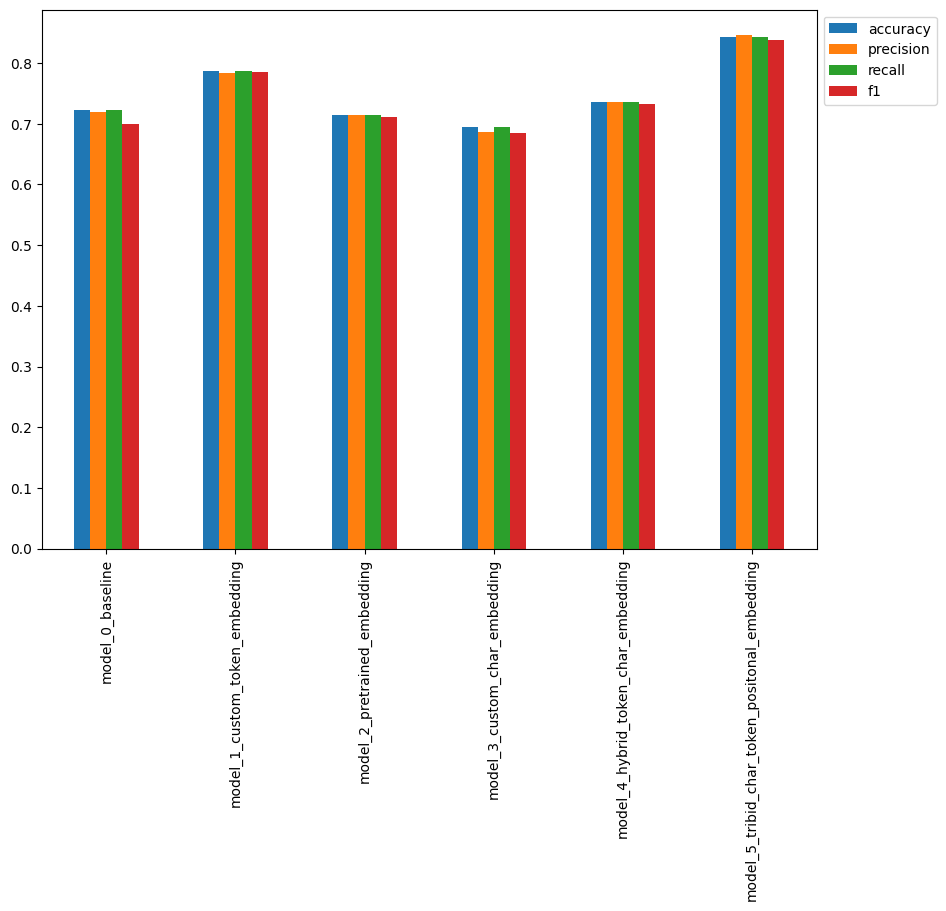

In [ ]:
all_model_results.plot(kind="bar" , figsize =(10,7)).legend(bbox_to_anchor =(1.0,1.0))

<Axes: >

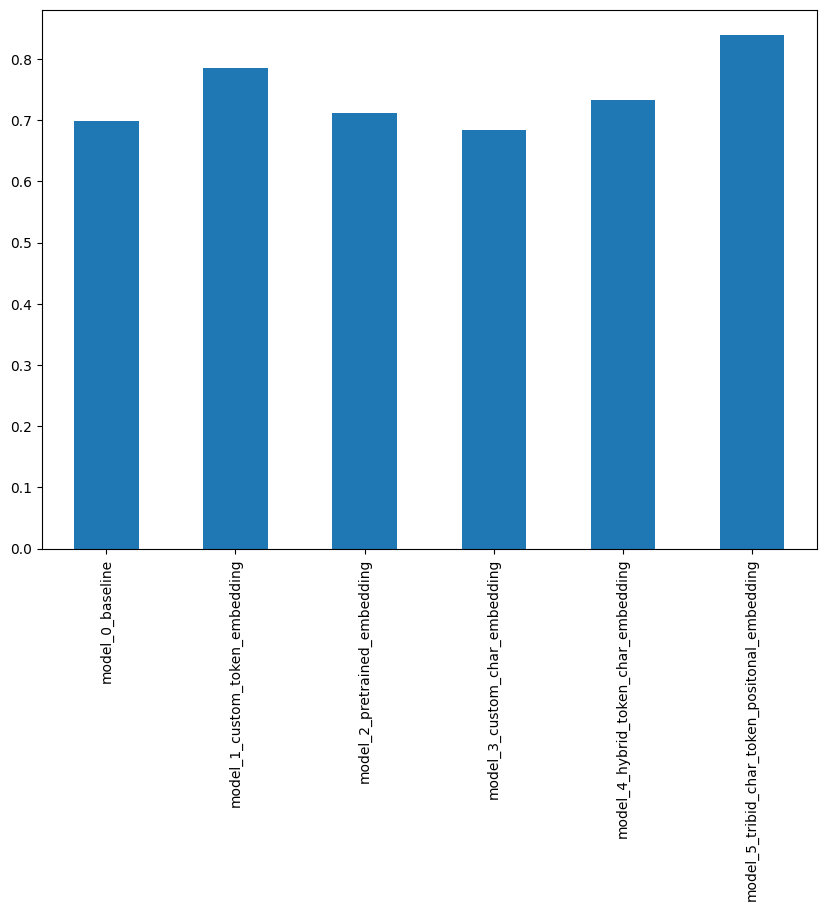

In [ ]:
all_model_results["f1"].plot(kind ="bar" , figsize=(10,7))

## Save and load model

In [ ]:
# saving the model

model_5.save("SkimLit_Model")

In [ ]:
from google.colab import files
files.download("SkimLit_Model")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Load in Best performing model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Projects/SkimLit_Model")


In [ ]:
# Make prediction with the Loaded model on validation set

loaded_pred_probs = loaded_model.predict(valid_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis =1 )


In [ ]:
loaded_model_results = calculate_results(y_true = val_labels_encoded ,
                  y_pred = loaded_preds)

loaded_model_results

{'accuracy': 84.22481133324507,
 'precision': 0.8455080083417329,
 'recall': 0.8422481133324506,
 'f1': 0.8385616210270436}

In [ ]:
model_5_results

{'accuracy': 84.22481133324507,
 'precision': 0.8455080083417329,
 'recall': 0.8422481133324506,
 'f1': 0.8385616210270436}

In [ ]:
model_5_results == loaded_model_results

True

In [ ]:
loaded_model.summary()

Model: "model_40"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_25 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_26[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_25[0][0]']        

### Download and load in a pretrained model from google storage

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text = """SARS-CoV-2 is a member of the family of coronaviruses. The first cases were recorded in Wuhan, China, between December 2019 and January 2020. Italy is one of the most affected countries in Europe. COVID-19 is a new challenge in modern dentistry. New guidelines are required in dental clinics to avoid contagion caused by cross-infections. A narrative review was performed using both primary sources, such as scientific articles and secondary ones, such as bibliographic indexes, web pages, and databases. The main search engines were PubMed, SciELO, and Google Scholar. Twelve articles were selected to develop the bibliographic review by applying pre-established inclusion and exclusion criteria. Precautionary measures should be applied to control COVID-19 in clinical practice. Several authors have highlighted the importance of telephone triage and/or clinic questionnaires, body temperature measurement, usage of personal protective equipment, surface disinfection with ethanol between 62% and 71%, high-speed instruments equipped with an anti-retraction system, four-handed work, and large-volume cannulas for aspiration. Clinically, the use of a rubber dam is essential. FFP2 (or N95) and FFP3 respirators, if compared to surgical masks, provide greater protection for health workers against viral respiratory infections. Further accurate studies are needed to confirm this.
        """

In [ ]:
type(text)

str

In [ ]:
def split_chars(text):
  return " ".join(list(text))


In [ ]:
classes = ['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS']
new_classes = [3, 0, 2, 4, 1]
def new_text(pred_results , classes , sent_list):
  new_string = ""

  ans = ""
  for i in new_classes:
    if i in pred_results:
      new_string = "\n\n"+classes[i]+":"
      for j in range(len(pred_results)):
        if pred_results[j]== i:
          new_string += sent_list[j]+"."
      ans += new_string
  return ans

In [ ]:
import numpy as np
import tensorflow as tf
def abstract_extraction(text , classes = classes , new_classes = new_classes , model = loaded_model):
  sent_list = text.split('.')
  char_sent_list = [split_chars (sentence ) for sentence in sent_list]
  total_lines = len(sent_list)
  lines = np.arange(total_lines)
  total_lines = np.array([total_lines])
  lines_one_hot =tf.one_hot(lines , depth = 16)
  total_lines_onehot = tf.one_hot(total_lines , depth = 20).numpy()
  new_array = np.ones(shape =(int(total_lines), 1))
  total_lines_one_hot = new_array*total_lines_onehot
  total_lines_onehot = tf.cast(tf.constant(total_lines_one_hot), dtype = tf.float32)
  dataset = (tf.constant(sent_list) , tf.constant(char_sent_list) , lines_one_hot , total_lines_onehot)
  pred = loaded_model.predict(x = dataset)
  pred_results = tf.argmax(pred , axis = 1)
  print(pred_results)
  ans = new_text(pred_results, classes , sent_list)
  print(ans)
  return ans


ans = abstract_extraction(text)
ans


1/1 [==============================] - 0s 409ms/step
tf.Tensor([0 0 0 2 2 2 4 2 2 4 4 4 1 0 1 1 0 1 0 1 1 0], shape=(22,), dtype=int64)


BACKGROUND:Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).0123).0716).e.
      .

METHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis.i.d.

RESULTS: Among the 84 subjects randomized in the main tria

"\n\nBACKGROUND:Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).0123).0716).e.\n      .\n\nMETHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis.i.d.\n\nRESULTS: Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t. and 12 received placebo for 12-week

In [ ]:
text = """Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.
      """
abstract_extraction(text)

1/1 [==============================] - 0s 158ms/step
tf.Tensor([0 0 0 2 2 2 4 2 2 4 4 4 1 0 1 1 0 1 0 1 1 0], shape=(22,), dtype=int64)


BACKGROUND:Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).0123).0716).e.
      .

METHODS: Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis.i.d.

RESULTS: Among the 84 subjects randomized in the main tria